### Efficient Partial Dependence Plots with decision trees


By now, I am pretty sure that the original description of the algorithm in the Friedman paper is incorrect (also observed by the author of the stackoverflow question).
By following only one child of splits on $X_0$ one computes conditional PDPs and not interventional PDPs.
I do not believe it possible to compute the latter with just one pass through the tree, it requires a full pass of the entire training data. 
The only speedup that my proposed algorithm offers is that one full pass is sufficient for all values of $X_0$!
And to achieve that, one has to follow both children of $X_0$.

Why do we need to pass all data? Because the splits on $X_C$ can be very different depending on the $X_0$ condition due to **correlations among the features**.
The following shows a simple extreme example to illustrate this point.


## Conditional versus Interventional

Both in his [paper](https://jerryfriedman.su.domains/ftp/trebst.pdf) and in the ESLII book, Friedman elaborates on how the **conditional** $E[f(x_S,X_C)|X_S=x_s]$ is different from the **interventional** $E[f(x_S,X_C)| \mathbf{do}(X_S=x_s)]$.

### Correlated Features

I will use a data set with just two binary features $X_{0,1}$ but strong correlations to illustrate the issues:

$$
P( X_1 = 1 | X_0 = 0) = 0.2, P( X_1 = 1 | X_0 = 1) = 0.8
$$

For $Y$ we somewhat randomly choose the following:
$$
E(Y | X_1 = 0, X_0 = 0) = 0.3, E(Y | X_1 = 1, X_0 = 0) = 0.7
$$
$$
E(Y | X_1 = 0, X_0 = 1) = 0.9, E(Y | X_1 = 1, X_0 = 1) = 0.1
$$

In [1]:
#import seaborn
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

Generate the data

In [55]:
#first X:
# 
N = 400; p0 = 0.5; p11 = 0.8; M=2
X = np.zeros((N,M)) # a matrix (N * M)
N1 = int(p0*N)
X[0:N1,0] = 1
X[0:int(p11*N1),1] = 1
X[N1:(N1+int((1-p11)*(N-N1))+1),1] = 1
df = pd.DataFrame(X, columns=["X0", "X1"])
##double check:
pd.crosstab(df['X0'],df['X1'])

X1,0.0,1.0
X0,,
0.0,160,40
1.0,40,160


In [56]:
#then Y:
# 
# y = np.zeros(N)
#E(Y | X_1 = 0, X_0 = 0) = 0.3
y[(X[:,0] == 0) & (X[:,1] == 0)] = 0.3
#E(Y | X_1 = 1, X_0 = 0) = 0.7
y[(X[:,0] == 0) & (X[:,1] == 1)] = 0.7
#E(Y | X_1 = 0, X_0 = 1) = 0.9 
y[(X[:,0] == 1) & (X[:,1] == 0)] = 0.9
#E(Y | X_1 = 1, X_0 = 1) = 0.1
y[(X[:,0] == 1) & (X[:,1] == 1)] = 0.1

#y = y + np.random.normal(0, 0.01, N)

In [57]:
##double check:
df = pd.DataFrame(X, columns=["X0", "X1"])
df["y"] = y
df.groupby(['X0', 'X1']).mean()

y
X0  X1      
0.0 0.0  0.3
    1.0  0.7
1.0 0.0  0.9
    1.0  0.1

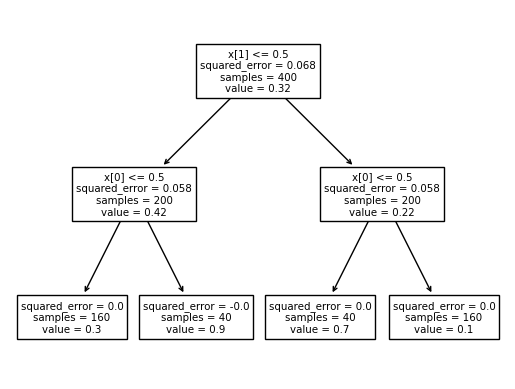

In [58]:
model = DecisionTreeRegressor(max_depth=2, max_features = 2)
model.fit(df[["X0","X1"]], y);
tree.plot_tree(model);

Since the tree split on $X_1$ first, the partial dependence values computed by `partial_dependence` will be different for $X_1$ if we shoose brute search versus `method = "recursion"`:

In [63]:
features = ["X1"]
for f in features:
    pdp_interventional = partial_dependence(model, df[["X0","X1"]], f,method = "brute")
    pdp_conditional = partial_dependence(model, df[["X0","X1"]], f,method = "recursion")
    
    print(f, "brute (interventional):", pdp_interventional['average'])
    print(f, "recursion (conditional):", pdp_conditional['average'])

X1 brute (interventional): [[0.6 0.4]]
X1 recursion (conditional): [[0.42 0.22]]


When we set `method = "recursion"` we get $E[f(X_S,X_C)|X_S=x_s]$ which is simply the average prediction on the **subset**  of terminal nodes reached by the conditional data!